# Federated Insurance

Open

- [ ] RSquared for FL, but it is only available in tf-nightly and the installation broke the env
- [ ] cache result

## Prerequisites
---

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split


from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_fed
#import FLutils

2023-05-12 06:31:51.522300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 06:31:52.224360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data preperation
---

In [2]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3'][:5]
target = 'charges'

df.loc[:, [target]+features].head(3)

,charges,age,sex,bmi,children,smoker
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0


In [4]:
# create client data
# ==================

clients = [
    df.loc[df['region'] == x, [target] + features] for x in df['region'].unique()]

# or randomly
# clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

print("clients shape: %s" % [client.shape for client in clients])

clients shape: [(325, 6), (364, 6), (325, 6), (324, 6)]


## Evaluation split
---

In [5]:
# create evaluation splits
# ========================

nreps, nfolds = 10, 5

rsmp = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(rsmp.split(data)) for data in clients]


print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

number of splits per client: [50, 50, 50, 50]


## Federated Learning
---

In [6]:
# define model architecture
def keras_blueprint(compile = False):
    return create_keras_model(
        nfeatures = len(features), 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

keras_blueprint().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


2023-05-12 06:31:54.604556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 06:31:54.656412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 06:31:54.656536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 06:31:54.660036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 06:31:54.660150: I tensorflow/compile

### FED Train 

In [7]:
# compute train

results_fed = []

for eval_ind in tqdm.tqdm(range(nreps * nfolds)):

    # fetch train, eval data and prep it
    train_data_fed = []
    eval_data_fed  = []

    for client_ind in range(len(clients)):
        indices_train = client_splits[client_ind][eval_ind][0]

        data = clients[client_ind].iloc[indices_train]
        train_data, eval_data = train_test_split(data, test_size = 0.1, random_state = 42)

        train_data_fed.append(prep_fed_train(train_data[features], train_data[target])) 
        eval_data_fed.append(prep_fed_test(eval_data[features], eval_data[target]))
        
    # train
    #with tf.device('/device:gpu:0'):
    result = train_fed(
        model = model_fn(keras_creator = keras_blueprint),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        NUM_ROUNDS = 50,
        NUM_EPOCHS = 50,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )

    results_fed.append(result)

  0%|          | 0/50 [00:00<?, ?it/s]2023-05-12 06:31:59.309915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 06:31:59.309988: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 06:31:59.310128: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 06:31:59.310639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 06:31:59.310717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support

In [8]:
# show final train result
pd.DataFrame([result['history'][-1] for result in results_fed]).describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,50.00,50.00,50.00,50.00,50.0,50.00,50.0,50.00,50.0,50.0
mean,2045.29,24517114.00,2046.71,48120.00,378.2,2407.63,28237300.0,2416.17,108.0,4.0
std,81.95,1441627.62,81.75,40.41,0.4,426.11,7619592.5,425.61,0.0,0.0
min,1884.21,22112916.00,1871.24,48100.00,378.0,1697.00,15828365.0,1691.94,108.0,4.0
25%,1997.22,23371772.50,1997.35,48100.00,378.0,2097.85,22806117.0,2131.13,108.0,4.0
50%,2044.43,24602990.00,2046.73,48100.00,378.0,2326.59,27091276.0,2338.78,108.0,4.0
75%,2111.41,25672016.00,2101.22,48100.00,378.0,2675.68,32351570.0,2701.46,108.0,4.0
max,2223.79,27465738.00,2210.09,48200.00,379.0,3598.20,48804696.0,3595.30,108.0,4.0


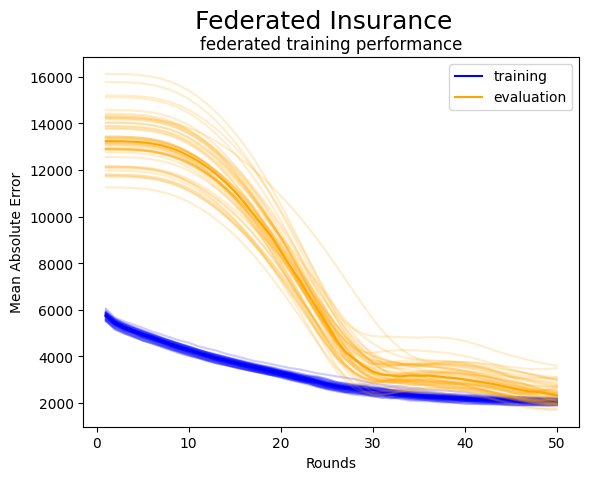

In [9]:
# plot train result

y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.show()

### FED Test

In [10]:
# compute test 
results_fed_test = []

for i in tqdm.tqdm(range(nfolds * nreps)):

    # fetch test data
    clients_test = []
    for client_ind in range(len(clients)):
        indices_test = client_splits[client_ind][eval_ind][1]
        clients_test.append(clients[client_ind].iloc[indices_test])

    test_data = pd.concat(clients_test)
    X_test = test_data[features]
    y_test = test_data[target]

    # calculate test performance
    model = keras_blueprint(compile = True)
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)

100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


In [11]:
# show test results
pd.DataFrame(results_fed_test).describe()[1:]

,loss,mae,mean_squared_error,r2_score
mean,2509.590840,2509.590835,3.255462e+07,0.673166
std,106.830137,106.830138,1.547808e+06,0.011948
min,2341.524414,2341.524414,2.983973e+07,0.640154
25%,2440.205811,2440.205811,3.131545e+07,0.667164
50%,2490.245728,2490.245728,3.261088e+07,0.672514
75%,2545.637268,2545.637268,3.322926e+07,0.682293
max,2941.087891,2941.087891,3.746653e+07,0.694616


## Centralized DNN
---

### CTR Train
---

In [12]:
# compute train
results_ctr = []

for i in tqdm.tqdm(range(nfolds * nreps)):
    train_indices = [split[1][0] for split in client_splits]
    #test_indices = [split[1][1] for split in client_splits]

    data_train = pd.concat([clients[i].iloc[train_indices[i]] for i in range(len(clients))])
    X_train = data_train[features]
    y_train = data_train[target]

    model = keras_blueprint(compile = True)
    
    tf.keras.utils.set_random_seed(42)

    hist = model.fit(
        X_train, y_train,
        batch_size = 128, 
        shuffle    = True,
        validation_split = 0.2,
        epochs     = 100,
        verbose    = 0 #2 # one line
        #, callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")]
    )
    results_ctr.append(hist)




100%|██████████| 50/50 [35:28<00:00, 42.57s/it]


In [13]:
# show train results
pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
).describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,1914.57,103.36,1575.15,1946.89,1946.89,1946.89,2038.94
mae,1914.57,103.36,1575.15,1946.89,1946.89,1946.89,2038.94
mean_squared_error,22392920.00,1099834.93,18937274.00,22765228.00,22765242.00,22765397.50,23166742.00
r2_score,85.58,0.65,85.12,85.34,85.34,85.36,87.67
val_loss,2288.30,98.87,1942.46,2287.67,2287.67,2287.71,2456.98
val_mae,2288.30,98.87,1942.46,2287.67,2287.67,2287.71,2456.98
val_mean_squared_error,24672618.84,495449.84,22840894.00,24694206.50,24694224.00,24694428.00,25476326.00
val_r2_score,77.08,0.43,76.43,77.05,77.05,77.05,78.67


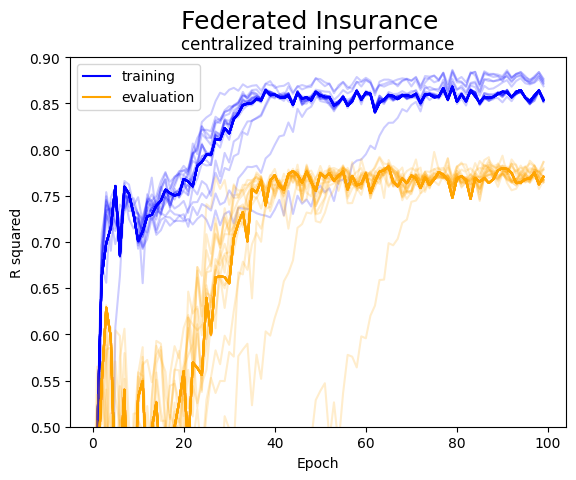

In [14]:
# plot train result
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epoch")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('centralized training performance')
plt.legend()
plt.show()

### CTR Test
---

In [15]:
# compute test
results_test_ctr = []

for i in tqdm.tqdm(range(nfolds * nreps)):
    #train_indices = [split[1][0] for split in client_splits]
    test_indices = [split[1][1] for split in client_splits]

    data_test = pd.concat([clients[i].iloc[test_indices[i]] for i in range(len(clients))])
    X_test = data_test[features]
    y_test = data_test[target]

    model = results_ctr[i].model
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


In [16]:
# show test results
pd.DataFrame(results_test_ctr).describe()[1:]

,loss,mae,mean_squared_error,r2_score
mean,2569.762632,2569.762632,3.391384e+07,0.645836
std,93.881934,93.881934,9.510597e+05,0.007514
min,2234.043213,2234.043213,3.090248e+07,0.635765
25%,2593.843506,2593.843506,3.411534e+07,0.645034
50%,2593.844971,2593.844971,3.411534e+07,0.645036
75%,2593.845215,2593.845215,3.411548e+07,0.645036
max,2656.939941,2656.939941,3.494598e+07,0.670459
